[![Roboflow Notebooks](https://media.roboflow.com/notebooks/template/bannertest2-2.png?ik-sdk-version=javascript-1.4.3&updatedAt=1672932710194)](https://github.com/roboflow/notebooks)

# YOLOv8 Tracking and Counting

---

[![YouTube](https://badges.aleen42.com/src/youtube.svg)](https://youtu.be/OS5qI9YBkfk)
[![Roboflow](https://raw.githubusercontent.com/roboflow-ai/notebooks/main/assets/badges/roboflow-blogpost.svg)](https://blog.roboflow.com/yolov8-tracking-and-counting/)
[![GitHub](https://badges.aleen42.com/src/github.svg)](https://github.com/roboflow/notebooks)

Ultralytics YOLOv8 is the latest version of the YOLO (You Only Look Once) object detection and image segmentation model developed by Ultralytics. The YOLOv8 model is designed to be fast, accurate, and easy to use, making it an excellent choice for a wide range of object detection and image segmentation tasks. It can be trained on large datasets and is capable of running on a variety of hardware platforms, from CPUs to GPUs.

## ⚠️ Disclaimer

This is an updated version of our [how-to-track-and-count-vehicles-with-yolov8](https://colab.research.google.com/github/roboflow-ai/notebooks/blob/main/notebooks/how-to-track-and-count-vehicles-with-yolov8.ipynb) notebook, using the latest [supervision](https://github.com/roboflow/supervision) APIs.

## Accompanying Blog Post

We recommend that you follow along in this notebook while reading the [blog post](https://blog.roboflow.com/yolov8-tracking-and-counting/) on how to train YOLOv8 Tracking and Counting, concurrently.

## Pro Tip: Use GPU Acceleration

If you are running this notebook in Google Colab, navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`. This will ensure your notebook uses a GPU, which will significantly speed up model training times.

## Steps in this Tutorial

In this tutorial, we are going to cover:

- Before you start
- Download video
- Install YOLOv8
- Install ByteTrack
- Install Roboflow Supervision
- Tracking utils
- Load pre-trained YOLOv8 model
- Predict and annotate single frame
- Predict and annotate whole video

**Let's begin!**

## Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jul  8 13:24:57 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [33]:
import os
HOME = os.getcwd()
print(HOME)

/content


## Download video

In [ ]:
!pip install -q gdown
%cd {HOME}
!gdown '1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-'

/content
Downloading...
From: https://drive.google.com/uc?id=1pz68D1Gsx80MoPg-_q-IbEdESEmyVLm-
To: /content/vehicle-counting.mp4
100% 35.3M/35.3M [00:00<00:00, 165MB/s]


In [36]:
SOURCE_VIDEO_PATH = f"{HOME}/red_light.mp4"

## Install YOLOv8

If you notice that our notebook behaves incorrectly - especially if you experience errors that prevent you from going through the tutorial - don't hesitate! Let us know and open an [issue](https://github.com/roboflow/notebooks/issues) on the Roboflow Notebooks repository.

In [23]:
!pip install ultralytics

from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.2.51 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 30.4/78.2 GB disk)


## Install Roboflow Supervision

In [24]:
!pip install supervision

from IPython import display
display.clear_output()

import supervision as sv
print("supervision.__version__:", sv.__version__)

supervision.__version__: 0.21.0


## Load pre-trained YOLOv8 model

In [27]:
MODEL = "yolov8n.pt"

In [28]:
from ultralytics import YOLO

model = YOLO(MODEL)
model.fuse()

100%|██████████| 6.25M/6.25M [00:00<00:00, 160MB/s]

YOLOv8n summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


## Predict and annotate single frame

In [37]:
# dict maping class_id to class_name
CLASS_NAMES_DICT = model.model.names

# class_ids of interest - car, motorcycle, bus and truck
selected_classes = [2, 3, 5, 7]

In [38]:
import supervision as sv
import numpy as np

SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


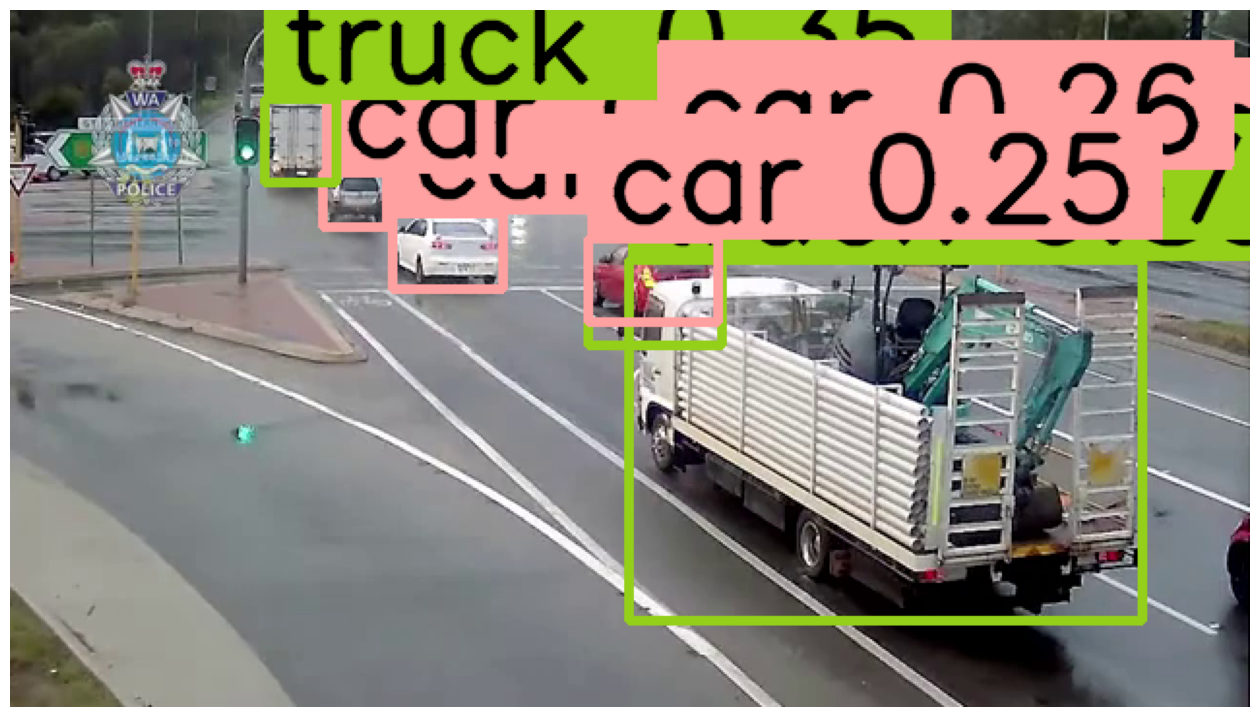

In [39]:
# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)
# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)
# acquire first video frame
iterator = iter(generator)
frame = next(iterator)
# model prediction on single frame and conversion to supervision Detections
results = model(frame, verbose=False)[0]

# convert to Detections
detections = sv.Detections.from_ultralytics(results)
# only consider class id from selected_classes define above
detections = detections[np.isin(detections.class_id, selected_classes)]

# format custom labels
labels = [
    f"{CLASS_NAMES_DICT[class_id]} {confidence:0.2f}"
    for confidence, class_id in zip(detections.confidence, detections.class_id)
]

# annotate and display frame
anotated_frame=box_annotator.annotate(scene=frame, detections=detections, labels=labels)

%matplotlib inline
sv.plot_image(anotated_frame, (16,16))

In [22]:
!ls /content/

intersection.mp4  yolov8x.pt


## Predict and annotate whole video

In [40]:
# settings
LINE_START = sv.Point(50, 1500)
LINE_END = sv.Point(3840-50, 1500)

TARGET_VIDEO_PATH = f"{HOME}/vehicle-counting-result-with-counter.mp4"

In [41]:
sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

VideoInfo(width=640, height=360, fps=18, total_frames=845)

In [42]:
# create BYTETracker instance
byte_tracker = sv.ByteTrack(track_thresh=0.25, track_buffer=30, match_thresh=0.8, frame_rate=30)

# create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# create LineZone instance, it is previously called LineCounter class
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# create LineZoneAnnotator instance, it is previously called LineCounterAnnotator class
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# define call back function to be used in video processing
def callback(frame: np.ndarray, index:int) -> np.ndarray:
    # model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    # only consider class id from selected_classes define above
    detections = detections[np.isin(detections.class_id, selected_classes)]
    # tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id
        in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]
    annotated_frame = trace_annotator.annotate(
        scene=frame.copy(),
        detections=detections
    )
    annotated_frame=box_annotator.annotate(
        scene=annotated_frame,
        detections=detections,
        labels=labels)

    # update line counter
    line_zone.trigger(detections)
    # return frame with box and line annotated result
    return  line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# process the whole video
sv.process_video(
    source_path = SOURCE_VIDEO_PATH,
    target_path = TARGET_VIDEO_PATH,
    callback=callback
)

SupervisionWarnings: `track_buffer` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'lost_track_buffer' instead.
SupervisionWarnings: `track_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'track_activation_threshold' instead.
SupervisionWarnings: `match_thresh` in `ByteTrack.__init__` is deprecated and will be remove in `supervision-0.23.0`. Use 'minimum_matching_threshold' instead.
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead
Supe

In [44]:
import numpy as np
import torch
import supervision as sv
import cv2
from torchvision import models, transforms

# Initialize the segmentation model
weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
segmentation_model = models.segmentation.deeplabv3_resnet101(weights=weights).eval()

# Define the transform to apply to the frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_lanes(frame: np.ndarray) -> np.ndarray:
    input_tensor = preprocess(frame).unsqueeze(0)
    with torch.no_grad():
        output = segmentation_model(input_tensor)['out'][0]
    mask = output.argmax(0).byte().cpu().numpy()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask

def color_lanes(frame: np.ndarray, mask: np.ndarray) -> np.ndarray:
    color = (0, 255, 0)  # Green color for lanes
    colored_frame = frame.copy()
    colored_frame[mask == 1] = color  # Assuming lane class is labeled as 1 in the mask
    return colored_frame

def check_vehicle_in_lane(vehicle_bbox: tuple, lane_mask: np.ndarray) -> bool:
    x1, y1, x2, y2 = vehicle_bbox
    vehicle_area = lane_mask[y1:y2, x1:x2]
    return np.any(vehicle_area == 1)  # Assuming lane class is labeled as 1 in the mask

# Initialize BYTETracker with updated parameters
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=30)

# Create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoxAnnotator
box_annotator = sv.BoxAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Define callback function
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Perform semantic segmentation for lanes
    lane_mask = segment_lanes(frame)

    # Color the lanes on the frame
    frame_with_lanes = color_lanes(frame, lane_mask)

    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = trace_annotator.annotate(scene=frame_with_lanes.copy(), detections=detections)
    annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Check if vehicles are in lanes
    for detection in detections:
        bbox = detection.bbox  # Assuming bbox is in the format (x1, y1, x2, y2)
        if check_vehicle_in_lane(bbox, lane_mask):
            cv2.putText(annotated_frame, "IN LANE", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Update line counter
    line_zone.trigger(detections)

    # Return frame with box, line, and lane annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the whole video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


SupervisionWarnings: annotate is deprecated: `BoxAnnotator` is deprecated and will be removed in `supervision-0.22.0`. Use `BoundingBoxAnnotator` and `LabelAnnotator` instead


AttributeError: 'tuple' object has no attribute 'bbox'

In [48]:
import numpy as np
import torch
import supervision as sv
import cv2
from torchvision import models, transforms

# Initialize the segmentation model
weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
segmentation_model = models.segmentation.deeplabv3_resnet101(weights=weights).eval()

# Define the transform to apply to the frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_lanes(frame: np.ndarray) -> np.ndarray:
    input_tensor = preprocess(frame).unsqueeze(0)
    with torch.no_grad():
        output = segmentation_model(input_tensor)['out'][0]
    mask = output.argmax(0).byte().cpu().numpy()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask

def color_lanes(frame: np.ndarray, mask: np.ndarray) -> np.ndarray:
    color = (0, 255, 0)  # Green color for lanes
    colored_frame = frame.copy()
    colored_frame[mask == 1] = color  # Assuming lane class is labeled as 1 in the mask
    return colored_frame

def check_vehicle_in_lane(vehicle_bbox: tuple, lane_mask: np.ndarray) -> bool:
    x1, y1, x2, y2 = vehicle_bbox
    vehicle_area = lane_mask[y1:y2, x1:x2]
    return np.any(vehicle_area == 1)  # Assuming lane class is labeled as 1 in the mask

# Initialize BYTETracker with updated parameters
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=30)

# Create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoundingBoxAnnotator
bbox_annotator = sv.BoundingBoxAnnotator(thickness=4)

# Create instance of LabelAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

# Create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Define callback function
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Perform semantic segmentation for lanes
    lane_mask = segment_lanes(frame)

    # Color the lanes on the frame
    frame_with_lanes = color_lanes(frame, lane_mask)

    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = trace_annotator.annotate(scene=frame_with_lanes.copy(), detections=detections)
    annotated_frame = bbox_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Check if vehicles are in lanes
    for detection in detections:
        bbox = detection[0:4]  # Assuming bbox is in the format (x1, y1, x2, y2)
        if check_vehicle_in_lane(bbox, lane_mask):
            cv2.putText(annotated_frame, "IN LANE", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Update line counter
    line_zone.trigger(detections)

    # Return frame with box, line, and lane annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the whole video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


TypeError: only integer scalar arrays can be converted to a scalar index

In [49]:
import numpy as np
import torch
import supervision as sv
import cv2
from torchvision import models, transforms

# Initialize the segmentation model
weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
segmentation_model = models.segmentation.deeplabv3_resnet101(weights=weights).eval()

# Define the transform to apply to the frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_lanes(frame: np.ndarray) -> np.ndarray:
    input_tensor = preprocess(frame).unsqueeze(0)
    with torch.no_grad():
        output = segmentation_model(input_tensor)['out'][0]
    mask = output.argmax(0).byte().cpu().numpy()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask

def color_lanes(frame: np.ndarray, mask: np.ndarray) -> np.ndarray:
    color = (0, 255, 0)  # Green color for lanes
    colored_frame = frame.copy()
    colored_frame[mask == 1] = color  # Assuming lane class is labeled as 1 in the mask
    return colored_frame

def check_vehicle_in_lane(vehicle_bbox: tuple, lane_mask: np.ndarray) -> bool:
    x1, y1, x2, y2 = map(int, vehicle_bbox)  # Convert coordinates to integers
    vehicle_area = lane_mask[y1:y2, x1:x2]
    return np.any(vehicle_area == 1)  # Assuming lane class is labeled as 1 in the mask

# Initialize BYTETracker with updated parameters
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=30)

# Create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoundingBoxAnnotator
bbox_annotator = sv.BoundingBoxAnnotator(thickness=4)

# Create instance of LabelAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

# Create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Define callback function
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Perform semantic segmentation for lanes
    lane_mask = segment_lanes(frame)

    # Color the lanes on the frame
    frame_with_lanes = color_lanes(frame, lane_mask)

    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = trace_annotator.annotate(scene=frame_with_lanes.copy(), detections=detections)
    annotated_frame = bbox_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Check if vehicles are in lanes
    for detection in detections:
        bbox = detection[0:4]  # Assuming bbox is in the format (x1, y1, x2, y2)
        if check_vehicle_in_lane(bbox, lane_mask):
            cv2.putText(annotated_frame, "IN LANE", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Update line counter
    line_zone.trigger(detections)

    # Return frame with box, line, and lane annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the whole video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


TypeError: only length-1 arrays can be converted to Python scalars

In [52]:
import numpy as np
import torch
import supervision as sv
import cv2
from torchvision import models, transforms

# Initialize the segmentation model
weights = models.segmentation.DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1
segmentation_model = models.segmentation.deeplabv3_resnet101(weights=weights).eval()

# Define the transform to apply to the frames
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((520, 520)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def segment_lanes(frame: np.ndarray) -> np.ndarray:
    input_tensor = preprocess(frame).unsqueeze(0)
    with torch.no_grad():
        output = segmentation_model(input_tensor)['out'][0]
    mask = output.argmax(0).byte().cpu().numpy()
    mask = cv2.resize(mask, (frame.shape[1], frame.shape[0]), interpolation=cv2.INTER_NEAREST)
    return mask

def color_lanes(frame: np.ndarray, mask: np.ndarray) -> np.ndarray:
    color = (0, 255, 0)  # Green color for lanes
    colored_frame = frame.copy()
    colored_frame[mask == 1] = color  # Assuming lane class is labeled as 1 in the mask
    return colored_frame

def check_vehicle_in_lane(vehicle_bbox: tuple, lane_mask: np.ndarray) -> bool:
    if isinstance(vehicle_bbox, (tuple, list)):
        x1, y1, x2, y2 = map(int, vehicle_bbox)
    elif isinstance(vehicle_bbox, np.ndarray):
        x1, y1, x2, y2 = vehicle_bbox.astype(int).tolist()
    else:
        raise TypeError("Unsupported type for vehicle_bbox")

    vehicle_area = lane_mask[y1:y2, x1:x2]
    return np.any(vehicle_area == 1)  # Assuming lane class is labeled as 1 in the mask


# Initialize BYTETracker with updated parameters
byte_tracker = sv.ByteTrack(track_activation_threshold=0.25, lost_track_buffer=30, minimum_matching_threshold=0.8, frame_rate=30)

# Create VideoInfo instance
video_info = sv.VideoInfo.from_video_path(SOURCE_VIDEO_PATH)

# Create frame generator
generator = sv.get_video_frames_generator(SOURCE_VIDEO_PATH)

# Create LineZone instance
line_zone = sv.LineZone(start=LINE_START, end=LINE_END)

# Create instance of BoundingBoxAnnotator
bbox_annotator = sv.BoundingBoxAnnotator(thickness=4)

# Create instance of LabelAnnotator
label_annotator = sv.LabelAnnotator(text_thickness=4, text_scale=2)

# Create instance of TraceAnnotator
trace_annotator = sv.TraceAnnotator(thickness=4, trace_length=50)

# Create LineZoneAnnotator instance
line_zone_annotator = sv.LineZoneAnnotator(thickness=4, text_thickness=4, text_scale=2)

# Define callback function
def callback(frame: np.ndarray, index: int) -> np.ndarray:
    # Perform semantic segmentation for lanes
    lane_mask = segment_lanes(frame)

    # Color the lanes on the frame
    frame_with_lanes = color_lanes(frame, lane_mask)

    # Model prediction on single frame and conversion to supervision Detections
    results = model(frame, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)
    detections = detections[np.isin(detections.class_id, selected_classes)]

    # Tracking detections
    detections = byte_tracker.update_with_detections(detections)
    labels = [
        f"#{tracker_id} {model.model.names[class_id]} {confidence:0.2f}"
        for confidence, class_id, tracker_id in zip(detections.confidence, detections.class_id, detections.tracker_id)
    ]

    annotated_frame = trace_annotator.annotate(scene=frame_with_lanes.copy(), detections=detections)
    annotated_frame = bbox_annotator.annotate(scene=annotated_frame, detections=detections)
    annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections, labels=labels)

    # Check if vehicles are in lanes
    for detection in detections:
        bbox = detection[0:4]  # Assuming bbox is in the format (x1, y1, x2, y2)
        if check_vehicle_in_lane(bbox, lane_mask):
            cv2.putText(annotated_frame, "IN LANE", (bbox[0], bbox[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)

    # Update line counter
    line_zone.trigger(detections)

    # Return frame with box, line, and lane annotated result
    return line_zone_annotator.annotate(annotated_frame, line_counter=line_zone)

# Process the whole video
sv.process_video(
    source_path=SOURCE_VIDEO_PATH,
    target_path=TARGET_VIDEO_PATH,
    callback=callback
)


TypeError: only length-1 arrays can be converted to Python scalars

## 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.